# Clasificacion de enfermedades de la papa usando SVM

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import numpy as np
import mahotas as mt
import joblib

### Cargando datos y separando en conjunto de prueba y entrenamiento

In [29]:
# Cargar los datos desde el archivo CSV
data = pd.read_csv('dataset.csv')

# Dividir los datos en características (X) y etiquetas (y)
X = data[['mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b', 'contrast', 'correlation', 'inverse_difference_moments', 'entropy']]
y = data['type']

# Codificar las etiquetas
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test

,mean_r,mean_g,mean_b,stddev_r,stddev_g,stddev_b,contrast,correlation,inverse_difference_moments,entropy
1505,114.780045,124.308746,119.601517,41.411955,26.781844,45.961895,133.311504,0.937444,0.193157,11.833944
1660,130.882782,119.905945,102.533722,52.189429,50.230424,55.815518,492.433894,0.903812,0.116390,13.215109
889,137.470535,146.036575,124.397125,50.521080,51.683751,58.501449,910.306482,0.824933,0.113457,13.385556
306,159.429794,154.917679,112.155243,56.134773,55.676391,54.811330,774.867221,0.863730,0.093001,13.555973
1771,112.306671,113.660828,103.681564,42.281482,35.457587,46.051247,417.024091,0.854655,0.138416,12.833868
...,...,...,...,...,...,...,...,...,...,...
567,154.416977,153.896286,121.701324,45.409239,47.365123,60.768838,582.295082,0.864447,0.119189,12.923897
1679,102.147690,111.224304,90.500488,39.671461,32.736098,45.096190,220.949214,0.907770,0.143721,12.459592
849,113.003311,126.351593,114.660187,36.799677,30.700575,43.729775,287.986659,0.866694,0.113727,12.677651
963,138.364944,140.631470,117.472321,42.597958,38.277603,50.877392,705.869972,0.782916,0.089305,13.406424


### Creando modelo

In [30]:
# Crear un modelo SVM
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
# Entrenar el modelo en el conjunto de entrenamiento
svm_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test)

### Evaluando modelo

Accuracy: 0.9698375870069605
Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       0.97      0.97      0.97       196
 Potato___Late_blight       0.97      0.97      0.97       209
     Potato___healthy       0.96      0.92      0.94        26

             accuracy                           0.97       431
            macro avg       0.97      0.96      0.96       431
         weighted avg       0.97      0.97      0.97       431

Confusion Matrix:
 [[191   5   0]
 [  5 203   1]
 [  0   2  24]]


Text(0.5, 1.0, 'Matriz de Confusión')

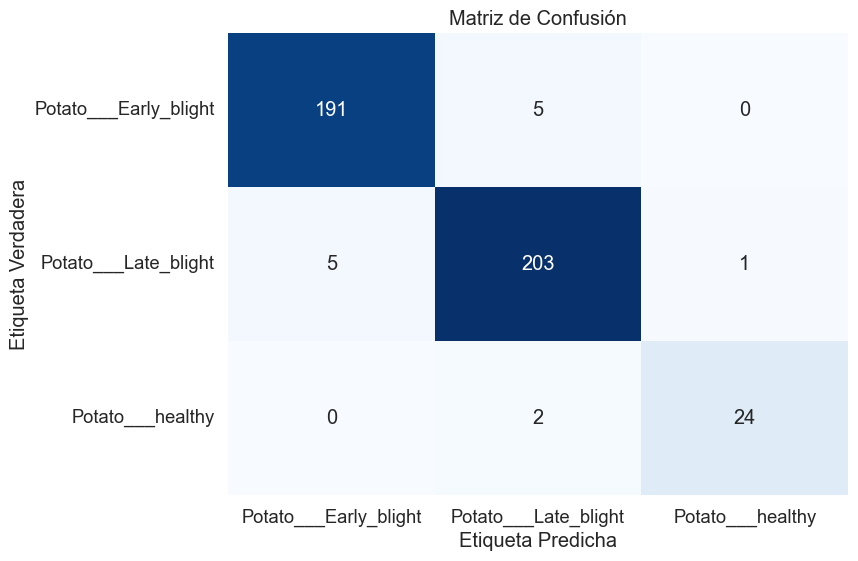

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
confusion = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

class_names = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Establece el tamaño de fuente de las etiquetas

# Usa Seaborn para crear un mapa de calor de la matriz de confusión
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Etiqueta los ejes y agrega un título
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')

In [32]:
## Guardando modelo:
joblib.dump(svm_model, 'modelo_svm.pkl')

['modelo_svm.pkl']

### Realizando predicciones

In [66]:
print("COMPROBANDO CON UNA IMAGEN NUEVA")
#funcion para extraer caracteristicas de color y textura de la imaegen de entrada
def extract_features(main_img):
    #main_img = cv2.imread(imgpath)    
    #preprocesamiento
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    
    #Caractersticas de color
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    blue_channel[blue_channel == 255] = 0
    green_channel[green_channel == 255] = 0
    red_channel[red_channel == 255] = 0
    
    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)
    
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)
    
    #Caracteristicas de Textura
    textures = mt.features.haralick(gs)
    ht_mean = textures.mean(axis=0)
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]
      
    vector = [red_mean,green_mean,blue_mean,red_std,green_std,blue_std,\
                contrast,correlation,inverse_diff_moments,entropy
                ]
    return vector

img_test = "../test_imagenes/late_8e.jpg"
main_img = cv2.imread(img_test) 
resized_img = cv2.resize(main_img, (255,255))

# Define los nombres de características para tus datos de entrada
feature_names = ['mean_r', 'mean_g', 'mean_b', 'stddev_r', 'stddev_g', 'stddev_b', 'contrast', 'correlation', 'inverse_difference_moments', 'entropy']

# Asigna los nombres de características a tus datos de entrada
feat = extract_features(main_img)
feat_test = pd.DataFrame([feat], columns=feature_names)

pred = svm_model.predict(feat_test)
print(pred)
etiqueta_predicha = label_encoder.inverse_transform(pred)
print("Etiqueta predicha:", etiqueta_predicha)

COMPROBANDO CON UNA IMAGEN NUEVA
[0]
Etiqueta predicha: ['Potato___Early_blight']
